# Assignment 2



*   Babandeep Singh
*   Robin Beura
*   Rahul Gera
*   Sanghmitra
*   Yash Patel


In [ ]:
import os 
from google.colab import drive
drive.mount("/content/drive")
os.chdir('/content/drive/Shared drives/IDS 576/Assignment 2')

Mounted at /content/drive


In [ ]:
%%sh
wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


--2020-10-01 18:58:55--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

     0K .......... .......... .......... .......... ..........  5%  543K 2s
    50K .......... .......... .......... .......... .......... 10% 1.06M 1s
   100K .......... .......... .......... .......... .......... 15% 91.2M 1s
   150K .......... .......... .......... .......... .......... 20% 78.2M 1s
   200K .......... .......... .......... .......... .......... 26% 1.07M 1s
   250K .......... .......... .......... .......... .......... 31%  194M 0s
   300K .......... .......... .......... .......... .......... 36%  293M 0s
   350K .......... .......... .......... .......... .......... 41% 70.0M 0s
   400K .......... ..

In [ ]:
import pandas as pd
import numpy as np
import itertools
from operator import eq
import scipy.sparse as sp
import pickle
import matplotlib.pyplot as plt
import torch

In [ ]:
### reading files
movies = pd.read_csv('ml-latest-small/movies.csv')

In [ ]:
movies.head()
##### removing year from name
movies['title'] = movies['title'].apply(lambda x : x[:-7])
movies['title']

0                                Toy Story
1                                  Jumanji
2                         Grumpier Old Men
3                        Waiting to Exhale
4              Father of the Bride Part II
                       ...                
9737    Black Butler: Book of the Atlantic
9738                 No Game No Life: Zero
9739                                 Flint
9740          Bungo Stray Dogs: Dead Apple
9741          Andrew Dice Clay: Dice Rules
Name: title, Length: 9742, dtype: object

In [ ]:
###### read ratings
ratings = pd.read_csv('ml-latest-small/ratings.csv').sort_values(by='movieId')
ratings = ratings.drop([0])
ratings

,userId,movieId,rating,timestamp
81531,517,1,4.0,1487954343
30517,213,1,3.5,1316196157
81082,514,1,4.0,1533872400
30601,214,1,3.0,853937855
30721,216,1,3.0,975211713
...,...,...,...,...
27256,184,193581,4.0,1537109082
27257,184,193583,3.5,1537109545
27258,184,193585,3.5,1537109805
27259,184,193587,3.5,1537110021


In [ ]:
#merging based on ratings to check what all other movies user has rated
df_out = ratings.merge(ratings, on='userId')
df_out

,userId,movieId_x,rating_x,timestamp_x,movieId_y,rating_y,timestamp_y
0,517,1,4.0,1487954343,1,4.0,1487954343
1,517,1,4.0,1487954343,2,3.0,1487954340
2,517,1,4.0,1487954343,10,0.5,1487957717
3,517,1,4.0,1487954343,17,0.5,1487953834
4,517,1,4.0,1487954343,34,5.0,1487954303
...,...,...,...,...,...,...,...
60893668,184,193587,3.5,1537110021,193579,3.5,1537107259
60893669,184,193587,3.5,1537110021,193581,4.0,1537109082
60893670,184,193587,3.5,1537110021,193583,3.5,1537109545
60893671,184,193587,3.5,1537110021,193585,3.5,1537109805


In [ ]:
#### creating movie embeddings
results = pd.crosstab(df_out.movieId_x, df_out.movieId_y) 
np.fill_diagonal(results.values, 0) #### replacing diagonals with zero
results.head()

movieId_y,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,68,31,2,32,57,32,5,12,69,42,15,6,12,8,41,44,12,55,8,47,22,11,18,42,10,5,7,19,1,17,104,84,37,4,59,1,8,4,5,...,1,1,1,1,1,1,1,5,3,1,1,3,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,68,0,26,3,22,36,18,6,3,56,29,9,6,4,9,28,22,10,51,7,33,17,6,12,19,7,6,4,12,1,16,59,56,20,4,43,0,6,2,5,...,2,1,0,1,0,0,0,5,4,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,31,26,0,1,19,25,19,4,9,23,13,10,3,6,5,20,13,7,26,5,24,11,4,10,16,6,5,2,5,0,10,30,17,19,2,20,1,6,4,4,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,3,1,0,3,2,6,1,0,4,3,0,1,1,1,2,5,0,3,0,4,2,0,2,4,2,1,1,1,0,4,3,4,4,0,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,32,22,19,3,0,24,23,4,9,20,16,6,3,9,3,13,19,8,21,2,17,9,4,9,20,6,6,2,6,0,12,30,22,18,2,19,0,5,1,6,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_out

,userId,movieId_x,rating_x,timestamp_x,movieId_y,rating_y,timestamp_y
0,517,1,4.0,1487954343,1,4.0,1487954343
1,517,1,4.0,1487954343,2,3.0,1487954340
2,517,1,4.0,1487954343,10,0.5,1487957717
3,517,1,4.0,1487954343,17,0.5,1487953834
4,517,1,4.0,1487954343,34,5.0,1487954303
...,...,...,...,...,...,...,...
60893668,184,193587,3.5,1537110021,193579,3.5,1537107259
60893669,184,193587,3.5,1537110021,193581,4.0,1537109082
60893670,184,193587,3.5,1537110021,193583,3.5,1537109545
60893671,184,193587,3.5,1537110021,193585,3.5,1537109805


In [ ]:
results.shape  ######## co-occurence matrix

(9724, 9724)

In [ ]:
import scipy
from sklearn import preprocessing

import pandas as pd
import numpy  as np

### scaling the data between 0 to 1
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(results)
df_normalized = pd.DataFrame(x_scaled)
# df_normalized.head()

movie_matrix = df_normalized.to_numpy()

In [ ]:
print(movie_matrix)
movie_matrix.shape[0]

[[0.         0.75555556 0.775      ... 0.         0.         0.        ]
 [0.44444444 0.         0.65       ... 0.         0.         0.        ]
 [0.20261438 0.28888889 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


9724

In [ ]:
#converting Xij data into a tensor

movie_matrix_tensor = torch.from_numpy(movie_matrix)
movie_matrix_tensor

tensor([[0.0000, 0.7556, 0.7750,  ..., 0.0000, 0.0000, 0.0000],
        [0.4444, 0.0000, 0.6500,  ..., 0.0000, 0.0000, 0.0000],
        [0.2026, 0.2889, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

# Compute data Xi,j from the movielens (small) dataset (data and description).

# Briefly describe your data prep workflow (you can use pandas if needed).

We imported the data from movieLens and removed the year from the movie title, as we need to recommend the movie, irrespective of year. 

Followed by, made a self pivot table, within movie based on userID - meaning how many users have rated that particular movie. 

Followed by, some preprocessig to bring everything to a common scale, so as to reduce outlier effects and any bias present in highly watched movies. 

Followed by converting the X_ij to a tensor. 

In [ ]:
#creating an empty tensor containing normally distributed values
embedding_size = 50

V = np.empty([movie_matrix_tensor.shape[0] ,embedding_size], dtype=float)
mu, sigma = 0, 0.1 # mean and standard deviation

for i in range(movie_matrix_tensor.shape[0]):
    np.random.seed(i)
    V[i] = np.random.normal(mu, sigma, embedding_size)

movie_vector_tensor = torch.from_numpy(V)   ### normally distributed
print(movie_vector_tensor.shape)

torch.Size([9724, 50])


In [ ]:
from torch import nn
from torch import optim


class LinReg(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.n = nn.Parameter(torch.randn(input_dim, output_dim))
        
    def forward(self, X):
        return self.n

In [ ]:
def learn_model(optimizer_name, num_epochs, learn_rate):
  input_dm = movie_vector_tensor.shape[0]
  output_dm = 10
  learning_rate  = learn_rate
  y_predictions = []
  
  running_loss = 0.0
  loss_history = np.arange(0,num_epochs)

  model= LinReg(input_dm,output_dm)                                                            
  criterion = nn.MSELoss(reduction = 'sum')
  if optimizer_name =='SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  elif optimizer_name =='Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  else:
    print('enter optimizer name: SGD or Adam')  

  
  if len(optimizer_name) >1:

    for i in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            n_vec = model(movie_vector_tensor)
            y_pred1 = torch.matmul(n_vec,n_vec.t())
            y_pred = y_pred1.type(torch.DoubleTensor)

            loss = criterion(y_pred, movie_matrix_tensor)

            loss.backward()
            optimizer.step()

            model.eval()               #model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time 
            with torch.no_grad():
                y_pred = model(movie_vector_tensor) 

            print(loss)
            loss_history[i] = loss

            y_predictions = y_pred
  
  
  plt.plot(np.arange(0,num_epochs),loss_history)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title(str(optimizer_name) + ' with learning Rate - '+ str(learn_rate))


  return loss_history, y_predictions


tensor(9.5632e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.3753e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(76299427.4471, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(50921486.2931, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(37540858.1788, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(29508637.9915, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(24267923.9513, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(20641685.6917, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(18019946.1468, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(16058525.9242, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(14550281.1401, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(13364043.3436, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(12413261.4414, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(11638842.7313, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(10999264.0382, dtyp

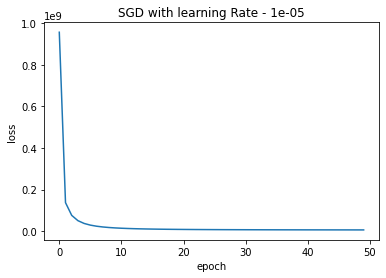

In [ ]:
sgd_loss_50, sgd_predictions_50 = learn_model('SGD',50, 0.00001)

tensor(9.5529e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.3751e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(76294568.7143, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(50922062.6466, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(37543645.8601, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(29512500.6790, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(24272391.0120, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(20646544.0425, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(18025096.2732, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(16063923.5347, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(14555910.9566, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(13369906.4699, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(12419368.9162, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(11645212.0941, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(11005917.4907, dtyp

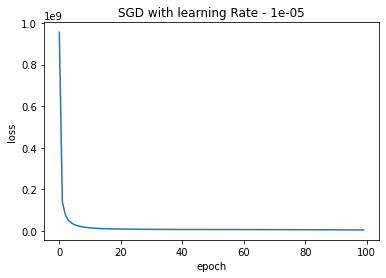

In [ ]:
sgd_loss_100, sgd_predictions_100 = learn_model('SGD',100, 0.00001)  #### loss dropped by almost 30% on increasing epoch to 100

tensor(9.5268e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5265e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5262e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5259e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5256e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5253e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5250e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5247e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5244e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5241e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5238e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5235e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5232e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5229e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(9.5226e+08, dtype=torch.float64, grad_fn=<MseLossBackwa

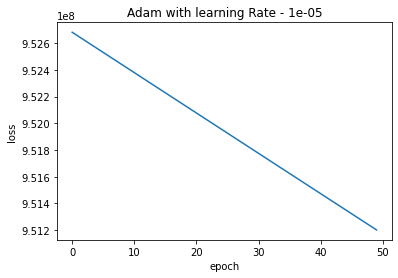

In [ ]:
adam_loss_50, adam_predictions_50 = learn_model('Adam',50, 0.00001) ###### learning rate should be higher with Adam optimizer in this scenario

tensor(9.4456e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(6.8428e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(4.9319e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(3.5541e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(2.5706e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.8725e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.3786e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.0297e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(78286598.3440, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(60749626.0607, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(48209603.0149, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(39164188.7321, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(32571112.2043, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(27708748.7125, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(24076682.1650, dtype=torch.float64, g

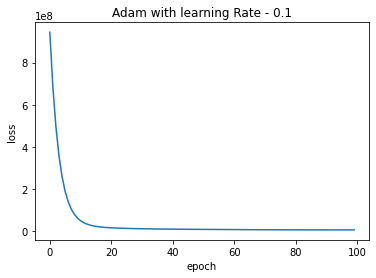

In [ ]:
adam_loss_100_01, adam_predictions_100_01 = learn_model('Adam',100, 0.1) ###### loss reduced considerably after increasing learning rate

tensor(9.4659e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.6118e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.5841e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(2.6429e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(2.8525e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.9610e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.2481e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(99867420.9015, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(99639181.9916, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(99571230.8036, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(86455759.1111, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(66405240.9305, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(50461306.8411, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(42296008.6546, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(40125837.8578, dtype=torch.float64

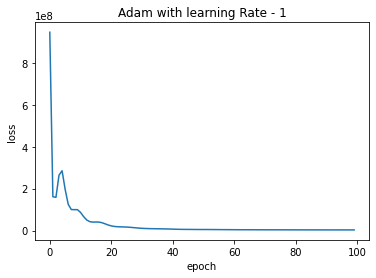

In [ ]:
adam_loss_100_1, adam_predictions_100_1 = learn_model('Adam',100, 1)     #### best results when learning rate is high and loss is stable after 40 epochs

tensor(9.4559e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.5891e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.5973e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(2.6597e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(2.8414e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.9452e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.2414e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.0004e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.0029e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.0008e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(86468060.0180, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(66109524.4867, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(50130381.7387, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(42046755.5911, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(39974595.4667, dtype=torch.float64, grad_fn

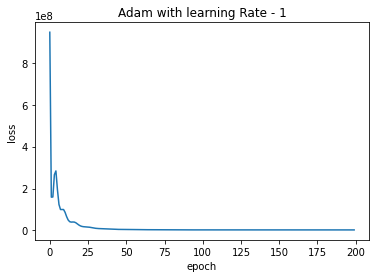

In [ ]:
adam_loss_200_1, adam_predictions_200_1 = learn_model('Adam',200, 1)     #### Trying 200 epochs

tensor(9.5481e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.5906e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.6033e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(2.6745e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(2.8615e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.9704e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.2624e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.0124e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(1.0050e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(99689847.7969, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(86292553.9208, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(66468070.5892, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(50795433.2571, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(42737574.8788, dtype=torch.float64, grad_fn=<MseLossBackward>)
tensor(40522302.9181, dtype=torch.float64, grad

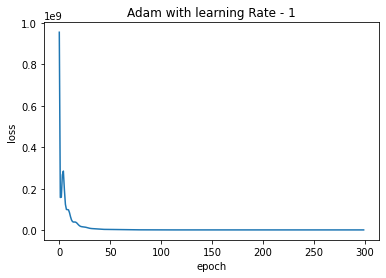

In [ ]:
adam_loss_300_1, adam_predictions_300_1 = learn_model('Adam',300, 1)     #### Trying 300 epochs

In [ ]:
#np.append(sgd_loss_50,[sgd_loss_50[-1]]*50).shape

(100,)

**# Plot for Loss as a function of iteration for different learning rates, choice of optimizers**

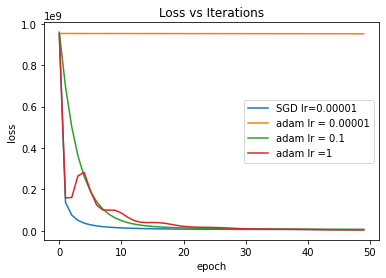

In [ ]:
num_epochs = 50
plt.plot(np.arange(0,num_epochs),sgd_loss_50,
         np.arange(0,num_epochs),adam_loss_50,
         np.arange(0,num_epochs),adam_loss_100_01[:50],
         np.arange(0,num_epochs),adam_loss_100_1[:50]
         )
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Iterations')
plt.legend(['SGD lr=0.00001', 'adam lr = 0.00001','adam lr = 0.1','adam lr =1'])

# **Top 10 Movies Recommendation**

Recommendation strategy being used here is cosine similarity. The reason is cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.

In [ ]:
####### cosine similarity
def cosine_similarity(movie_matrix, embedded_movie):
  similar_movies = []
  for movie in range(movie_matrix.shape[0]):
    cs=scipy.spatial.distance.cosine(embedded_movie,movie_matrix[movie,:])
    similar_movies.append(1-cs)
  return similar_movies


In [ ]:
######### function to pass arguments - optimizers and learning rate to get recommendations
def recommend_for(optimizer_selected, movie_Name,no_of_movies):
  if optimizer_selected =='SGD':  
    df = pd.DataFrame(sgd_predictions_100.data.numpy()) #### 100 epochs used here for better prediction
  elif optimizer_selected =='Adam_01':     ########## Here, 01 is for lr = 0.1
    df = pd.DataFrame(adam_predictions_100_01.data.numpy())
  elif optimizer_selected =='Adam_1': ############### 1 is for lr =1
    df = pd.DataFrame(adam_predictions_100_1.data.numpy())

  
  df.rename(index = dict(zip(df.index[0:], list(results.index))),inplace=True)
  df_matrix= df.to_numpy() 

  movies.rename(index = dict(zip(movies.index[0:],list(movies.iloc[:,0]))),inplace=True)
  # movies.head()

  index = movies.index[movies['title'] == movie_Name].to_list()
  movie_embedding = df.loc[index,:].to_numpy()

  movie_relation = pd.DataFrame(cosine_similarity(df_matrix,movie_embedding))
  movie_relation.rename(index = dict(zip(movie_relation.index[0:], list(results.index))),inplace=True)

  movie_relation.columns = ['movie We recommend']

  # sorting and getting the top n movie 
  movies_sorted = movie_relation.sort_values('movie We recommend',ascending=False)

  movie_w_name = pd.merge(movies_sorted, movies, left_index=True, right_index=True)

  return movie_w_name['title'][0:10]

In [ ]:

##### function to get recommendations for a movie in Xij matrix

def observed(moviename):
  #### getting movie index from movies given movie name
  indx = movies[movies["title"] == moviename].index[0]

  # Sorting top 10 movie indexes in results
  ob_indx = (-np.asanyarray(results.iloc[indx])).argsort()[:10]

  # Getting movie name from top 10 movie indexes
  recommendations = movies["title"].iloc[ob_indx]

  return recommendations

For Toy Story


In [ ]:
observed('Toy Story')   #### Recommendations according to frequency

314                                          Forrest Gump
257                                          Pulp Fiction
277                             Shawshank Redemption, The
224                    Star Wars: Episode IV - A New Hope
418                                         Jurassic Park
1938                                  Walk on the Moon, A
615                         Independence Day (a.k.a. ID4)
510                             Silence of the Lambs, The
97                                             Braveheart
910     Once Upon a Time in the West (C'era una volta ...
Name: title, dtype: object

In [ ]:
recommend_for('SGD','Toy Story',10)

1                                                Toy Story
2930                                     Return with Honor
7254                                  The Butterfly Effect
5820                     Standing in the Shadows of Motown
6337                                        Owning Mahowny
26854                    Darkman II: Return of Durant, The
930                                              Notorious
159690    Teenage Mutant Ninja Turtles: Out of the Shadows
3052                                                 Dogma
4808                                        Vanishing, The
Name: title, dtype: object

In [ ]:
recommend_for('Adam_01','Toy Story',10)

1                                   Toy Story
1682                         Truman Show, The
2003                                 Gremlins
2028                      Saving Private Ryan
1206                      Clockwork Orange, A
2019     Seven Samurai (Shichinin no samurai)
32         Twelve Monkeys (a.k.a. 12 Monkeys)
1302                          Field of Dreams
2683    Austin Powers: The Spy Who Shagged Me
8512                             Silent Movie
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Toy Story',10)

1                                 Toy Story
2716    Ghostbusters (a.k.a. Ghost Busters)
3977                       Charlie's Angels
1485                              Liar Liar
1682                       Truman Show, The
1923           There's Something About Mary
2355                          Bug's Life, A
356                            Forrest Gump
2959                             Fight Club
2918               Ferris Bueller's Day Off
Name: title, dtype: object

**The movies recommended for different optimizers and learning rates are also different. This is because the losses reduces more for lower learning rates and higher iterations and the choice of optimizer. In our case Adam has performed better on predictions than the rest of the optimizer with learning rate 1 and 100 iterations. However, if we increase our epochs to 200 or maybe 300, we'll get even more perfect recommendations.**

In [ ]:
recommend_for('Adam_1','Toy Story',10)    #### Using 200 epochs

1                                 Toy Story
2716    Ghostbusters (a.k.a. Ghost Busters)
1923           There's Something About Mary
4979                  Royal Tenenbaums, The
1136        Monty Python and the Holy Grail
1485                              Liar Liar
1270                     Back to the Future
1682                       Truman Show, The
2918               Ferris Bueller's Day Off
2355                          Bug's Life, A
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Toy Story',10)    #### Using 300 epochs

1                                 Toy Story
2716    Ghostbusters (a.k.a. Ghost Busters)
1923           There's Something About Mary
1136        Monty Python and the Holy Grail
1485                              Liar Liar
4979                  Royal Tenenbaums, The
1270                     Back to the Future
1682                       Truman Show, The
2918               Ferris Bueller's Day Off
2355                          Bug's Life, A
Name: title, dtype: object

For Apollo 13

In [ ]:
observed('Apollo 13')   #### Recommendations according to frequency

1                          Toy Story
303          Quick and the Dead, The
99     Heidi Fleiss: Hollywood Madam
95                      Broken Arrow
94                   Beautiful Girls
300                        Quiz Show
299                           Priest
296                     Pulp Fiction
673                        Space Jam
85                Angels and Insects
Name: title, dtype: object

In [ ]:
recommend_for('SGD','Apollo 13',10)

150                             Apollo 13
55269             Darjeeling Limited, The
8781            Manchurian Candidate, The
61073                           Hell Ride
5574                     Transporter, The
46574                     OH in Ohio, The
919                     Wizard of Oz, The
778                         Trainspotting
40583                             Syriana
105720    Thief of Paris, The (Le voleur)
Name: title, dtype: object

In [ ]:
recommend_for('Adam_01','Apollo 13',10)

150                                 Apollo 13
86142     13 Assassins (Jûsan-nin no shikaku)
1909           X-Files: Fight the Future, The
923                              Citizen Kane
4299                         Knight's Tale, A
1246                       Dead Poets Society
87232                      X-Men: First Class
1101                                  Top Gun
151745                             Reptilicus
1438                             Dante's Peak
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Apollo 13',10)

150                            Apollo 13
2054            Honey, I Shrunk the Kids
4571    Bill & Ted's Excellent Adventure
316                             Stargate
3254                     Wayne's World 2
2268                     Few Good Men, A
1608                       Air Force One
3247                          Sister Act
2641                         Superman II
1408           Last of the Mohicans, The
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Apollo 13',10)    #### Using 200 epochs

150                            Apollo 13
1608                       Air Force One
2054            Honey, I Shrunk the Kids
1266                          Unforgiven
4571    Bill & Ted's Excellent Adventure
3254                     Wayne's World 2
1302                     Field of Dreams
2268                     Few Good Men, A
733                            Rock, The
185                             Net, The
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Apollo 13',10)    #### Using 300 epochs

150                            Apollo 13
1608                       Air Force One
2054            Honey, I Shrunk the Kids
4571    Bill & Ted's Excellent Adventure
1266                          Unforgiven
3254                     Wayne's World 2
1302                     Field of Dreams
733                            Rock, The
2268                     Few Good Men, A
185                             Net, The
Name: title, dtype: object

For Home Alone

In [ ]:
observed('Home Alone')   #### Recommendations according to frequency

954        Mr. Smith Goes to Washington
647                  Courage Under Fire
1373    Star Trek V: The Final Frontier
637                          Sgt. Bilko
1379                      Young Guns II
1380                             Grease
628                         Primal Fear
1385                        Under Siege
1387                               Jaws
1392                       Citizen Ruth
Name: title, dtype: object

In [ ]:
recommend_for('SGD','Home Alone',10)

586                                   Home Alone
144522                                  Sky High
1385                                 Under Siege
931                                   Spellbound
2932                              Days of Heaven
922       Sunset Blvd. (a.k.a. Sunset Boulevard)
48774                            Children of Men
48560                      Running With Scissors
3798                           What Lies Beneath
3871                                       Shane
Name: title, dtype: object

In [ ]:
recommend_for('Adam_01','Home Alone',10)

586                    Home Alone
4015        Dude, Where's My Car?
466          Hot Shots! Part Deux
4010          Brewster's Millions
2835                 Chill Factor
6502                28 Days Later
4020                    Gift, The
55269     Darjeeling Limited, The
134130                The Martian
904                   Rear Window
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Home Alone',10)

586                              Home Alone
2717                        Ghostbusters II
3253                          Wayne's World
1387                                   Jaws
2124                     Addams Family, The
1073    Willy Wonka & the Chocolate Factory
733                               Rock, The
316                                Stargate
2006                     Mask of Zorro, The
185                                Net, The
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Home Alone',10)   #### Using 200 epochs

586                           Home Alone
2124                  Addams Family, The
2717                     Ghostbusters II
736                              Twister
2006                  Mask of Zorro, The
4571    Bill & Ted's Excellent Adventure
2054            Honey, I Shrunk the Kids
733                            Rock, The
185                             Net, The
3253                       Wayne's World
Name: title, dtype: object

In [ ]:
recommend_for('Adam_1','Home Alone',10)   #### Using 300 epochs

586                           Home Alone
2124                  Addams Family, The
2717                     Ghostbusters II
736                              Twister
2006                  Mask of Zorro, The
2054            Honey, I Shrunk the Kids
4571    Bill & Ted's Excellent Adventure
733                            Rock, The
185                             Net, The
3253                       Wayne's World
Name: title, dtype: object